## Step 1: Import Essential Libraries
In this step, we import the necessary Python libraries that will power our analysis and model building.

- Data Manipulation: pandas and numpy are used to load the CSV file and perform mathematical operations on the data.

- Visualization: seaborn and matplotlib are used to create charts (like heatmaps and histograms) that help us visually understand data patterns.

- Machine Learning (Scikit-Learn): This is the core library. We import tools for:

    - Preprocessing: converting text to numbers (OneHotEncoder) and scaling values (StandardScaler).

    - Model Training: The Random Forest Classifier algorithm.

    - Evaluation: Metrics like Accuracy, Recall, and ROC Curves to measure how well the model predicts heart disease.

    - Saving: pickle is crucial for saving the trained model so it can be used later by your FastAPI backend.

In [ ]:
# STEP 1: Import Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Scikit-learn modules for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc)

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Step 2: Load the Dataset
We load the dataset heart.csv into a Pandas DataFrame. This corresponds to the "Data Collection" phase of the project workflow. We display the first 5 rows (head()) and the dataset shape to confirm that the data has been loaded correctly and to get an initial look at features like Age, Sex, and Cholesterol.

In [ ]:
# STEP 2: Load Data
df = pd.read_csv('heart_disease_datasets.csv')

print("Dataset Loaded Successfully.")
print(f"Total Patients (Rows): {df.shape[0]}")
print(f"Total Attributes (Columns): {df.shape[1]}")
display(df.head())

Dataset Loaded Successfully.
Total Patients (Rows): 918
Total Attributes (Columns): 12


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Step 3: Exploratory Data Analysis (EDA)
Before we train any model, we must check if our dataset is "balanced."

- Why this matters: If we have 90% healthy patients and only 10% sick patients, the model might cheat by just guessing "Healthy" every time.

- The Visualization: The Count Plot below shows the ratio of Normal (0) vs. Heart Disease (1) cases. Ideally, these bars should be somewhat equal.

C:\Users\hp\AppData\Local\Temp\ipykernel_5584\2641793768.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='HeartDisease', data=df, palette='viridis')


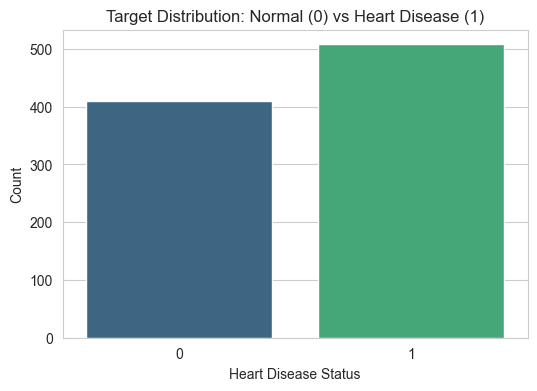


Missing Values Summary:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [ ]:
# STEP 3: Exploratory Data Analysis (EDA)
# Visualizing the target variable balance
plt.figure(figsize=(6, 4))
sns.countplot(x='HeartDisease', data=df, palette='viridis')
plt.title('Target Distribution: Normal (0) vs Heart Disease (1)')
plt.xlabel('Heart Disease Status')
plt.ylabel('Count')
plt.show()

# Check for standard missing values (NaN)
print("\nMissing Values Summary:")
print(df.isnull().sum())

## Step 4: Data Cleaning (Handling Hidden Errors)
Real-world medical data is rarely perfect. In this specific dataset, a Cholesterol level of 0 is recorded for several patients.

- The Problem: A living human cannot have 0 cholesterol; this is a data entry error representing a missing value.

- The Solution: Instead of deleting these rows (which would lose valuable data), we perform Imputation. We replace the 0 values with the Median cholesterol level of the dataset. This keeps the dataset size large while fixing the error.

In [ ]:
# STEP 4: Data Cleaning
# Count how many rows have Cholesterol = 0
zeros_count = df[df['Cholesterol'] == 0].shape[0]
print(f"\nEntries with 0 Cholesterol before cleaning: {zeros_count}")

# Replace 0 with NaN (Not a Number) temporarily, then fill with the Median
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
median_cholesterol = df['Cholesterol'].median()
df['Cholesterol'] = df['Cholesterol'].fillna(median_cholesterol)

print(f"Replaced 0 values with Median ({median_cholesterol}).")
print(f"Entries with 0 Cholesterol after cleaning: {df[df['Cholesterol'] == 0].shape[0]}")


Entries with 0 Cholesterol before cleaning: 172
Replaced 0 values with Median (237.0).
Entries with 0 Cholesterol after cleaning: 0


## Step 5: Feature Selection (Correlation Matrix)
We perform Correlation Analysis to identify relationships between numerical features.

- Why this matters: We want to see which features (like Age or Max Heart Rate) are most strongly related to the Target (HeartDisease).

- The Visualization: The Heatmap displays these relationships. Darker red/blue colors indicate stronger correlations. This justifies our selection of features for the model.

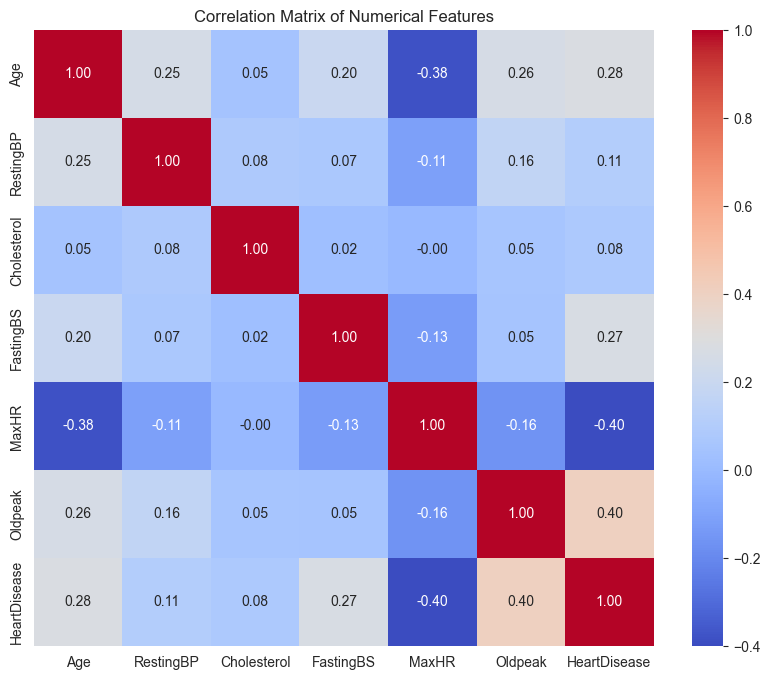

In [ ]:
# STEP 5: Feature Selection (Correlation Analysis)
# Select only numerical columns for the heatmap
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Step 6: Data Preprocessing Pipeline
This is a critical technical step. Machine Learning models only understand math, not text.

- Categorical Encoding: We use OneHotEncoder to convert text columns like Sex (Male/Female) and ChestPainType (ATA/ASY) into binary numbers (0s and 1s).

- Feature Scaling: We use StandardScaler to normalize numerical columns like Age (ranges 20-80) and Cholesterol (ranges 100-400) so they are on the same scale. This prevents larger numbers from dominating the model.

In [ ]:
# STEP 6: Preprocessing
# Separate Features (X) and Target (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Define which columns are Categorical vs Numerical
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']

# Create the transformer pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Apply transformations
X_processed = preprocessor.fit_transform(X)
print("Data Preprocessing Complete.")
print(f"Original Feature Count: {X.shape[1]}")
print(f"Processed Feature Count (after encoding): {X_processed.shape[1]}")

Data Preprocessing Complete.
Original Feature Count: 11
Processed Feature Count (after encoding): 15


## Step 7: Train-Test Split
To objectively evaluate our model, we cannot test it on the same data it learned from (that would be cheating).

- The Split: We divide the data into 80% Training Data (used to teach the model) and 20% Testing Data (held back for the final exam).

- random_state=42 ensures that if we run this code again, we get the exact same split, making our results reproducible.

In [ ]:
# STEP 7: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (734, 15)
Testing Data Shape: (184, 15)


## Step 8: Hyperparameter Tuning (GridSearchCV)
A standard Random Forest model has default settings that might not be optimal for your specific dataset.

- Grid Search: We define a "grid" of possibilities (e.g., trying 50 trees, then 100 trees, then 200 trees).

- Optimization: The computer trains a model for every single combination and tells us which one performed the best. This ensures your Final Year Project uses the mathematically best model possible, not just a default one.

In [ ]:
# STEP 8: Hyperparameter Tuning
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of trees in the forest
    'max_depth': [None, 10, 20],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]      # Minimum samples required to split a node
}

print("Starting Hyperparameter Tuning...")
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=1)

# Fit the search to the training data
grid_search.fit(X_train, y_train)

# Retrieve best parameters
best_params = grid_search.best_params_
print(f"Optimization Complete. Best Parameters: {best_params}")

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Optimization Complete. Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


## Step 9: Model Training (Final)
Now that we know the "Best Parameters" from the previous step, we train our final model using those specific settings. This model is now ready to predict heart disease patterns.

In [ ]:
# STEP 9: Model Training
# Get the best model from the grid search
best_model = grid_search.best_estimator_

# (Optional: Fit again to be explicit, though GridSearchCV does this automatically)
best_model.fit(X_train, y_train)
print("Final Model Trained with Optimized Parameters.")

Final Model Trained with Optimized Parameters.


## Step 10: Cross-Validation
We perform Cross-Validation to prove the model's reliability.

- Instead of trusting just one test score, we split the training data into 5 separate chunks (folds).

- We train and test 5 times. If the accuracy is consistent across all 5 times (e.g., 85%, 86%, 84%), we know the model is stable and robust.

In [ ]:
# STEP 10: Cross-Validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

Cross-Validation Accuracy Scores: [0.87755102 0.89115646 0.88435374 0.84353741 0.8630137 ]
Mean CV Accuracy: 0.8719


## Step 11: Advanced Evaluation
This is the most crucial part for your report. We evaluate the model on the Test Set (the 20% unseen data).

- Recall (Sensitivity): This is your priority. In heart disease, we must minimize False Negatives (telling a sick person they are healthy). A high Recall score means we are catching most disease cases.

- Confusion Matrix: A visual scorecard showing exactly how many correct and incorrect predictions the model made.

- ROC Curve: A graph showing the trade-off between sensitivity and specificity. A curve closer to the top-left corner is better.


--- Final Performance Metrics ---
Accuracy: 0.8587
Recall (Sensitivity): 0.8692
F1 Score: 0.8774


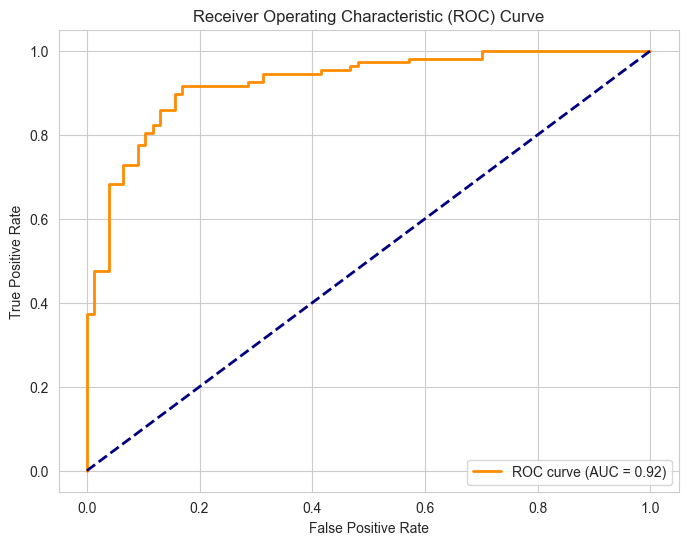

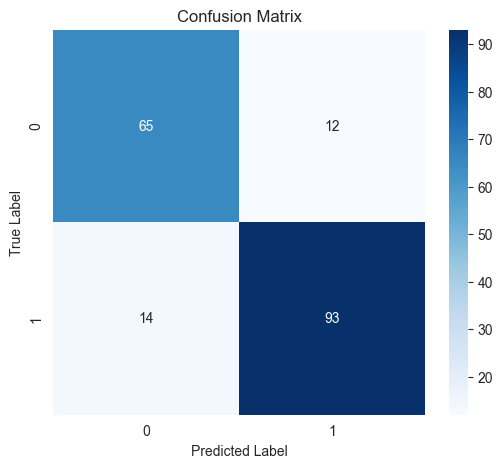

In [ ]:
# STEP 11: Final Evaluation
# Predict on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# 1. Print Numerical Metrics
print("\n--- Final Performance Metrics ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# 2. Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 3. Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Step 12: Save Model for Backend Integration
The final step bridges the gap between Machine Learning and Web Development.

- We save the Trained Model AND the Preprocessor into a single binary file (.pkl).

- Why the Preprocessor? When a user types "Male" on your website, your backend must know exactly how to convert "Male" into the number 0 or 1 that the model expects. Saving the preprocessor ensures the backend does this translation exactly the same way the training environment did.

In [ ]:
# STEP 12: Save Model & Preprocessor
model_data = {
    "model": best_model,
    "preprocessor": preprocessor
}

filename = 'heart_disease_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_data, file)

print(f"Model and Preprocessor successfully saved to '{filename}'.")

Model and Preprocessor successfully saved to 'heart_disease_model.pkl'.


In [ ]:
from sklearn.metrics import classification_report

# Assuming you have already trained the model and got predictions
# y_test = Actual values
# y_pred = Predicted values

print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Heart Disease']))


--- Detailed Classification Report ---
               precision    recall  f1-score   support

       Normal       0.82      0.84      0.83        77
Heart Disease       0.89      0.87      0.88       107

     accuracy                           0.86       184
    macro avg       0.85      0.86      0.86       184
 weighted avg       0.86      0.86      0.86       184

